In [154]:
!pip install nolds

In [155]:
#Basics
import pandas as pd
from pandas import DataFrame
import numpy as np
from datetime import datetime, timedelta

#Visuals
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (15,7)
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick


import seaborn as sns

#warnings.filterwarnings("ignore")

#!pip install nolds
import nolds


In [156]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

%cd /content/drive/My Drive/Thesis/Thesissub

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Thesis/Thesissub


In [157]:
ls

 actuals_LSTM_5.csv                     'EDA_running on ETH.ipynb'
 cleaned_BTC.csv                         predictions_LSTM_5.csv
 cleaned_ETH.csv                         predictions_LSTM_5_sun.csv
'Copy of Echo state.ipynb'               Results/
'Copy of Windows of Data_models.ipynb'  'Sklearn models.ipynb'
'Data Prep.ipynb'                        Sklearn_results/
 drop_features_list_BTC.csv              Untitled0.ipynb
 drop_features_list_ETH.csv             'Windows of Data_models.ipynb'
'Echo state.ipynb'


# Import data was that was prepped in Data Prep

In [158]:
#eth = pd.read_csv('eth_not_scaled_withClass.csv')
#eth = pd.read_csv('eth-prepped')
#df = eth
df =pd.read_csv('cleaned_ETH.csv')
#btc =pd.read_csv('btc_w_features.csv')
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df = df.dropna()


In [159]:
df.head()

,date,close,lag_3,lower_band,MIDPOINT_15,MIDPOINT_30,SAR,SMA_5,NEW_SMA_5,SMA_7,SMA_30,trima_15,WMA_5,WMA_7,WMA_14,WMA_30,roll_var_5,roll_var_7,roll_var_14,roll_var_30,5 Day STD,7 Day STD,14 Day STD,30 Day STD,ADX_5,ADX_10,ADX_30,ADXR_10,APO,aroondown,aroonup,aroon_osc,BOP,CCI_30,CMO_10,DX_10,macd,macdsignal,macdhist,MINUS_DI_10,MINUS_DM_10,MOM_10,PLUS_DI_10,PLUS_DM_10,PPO,roc_5,roc_10,roc_30,rsi_5,rsi_10,rsi_30,slowk,slowd,fastk,fastd,fastk_rsi,fastd_rsi,TRIX_10,ULTOSC,WILLR,HT_DCPERIOD,HT_DCTREND
0,2015-10-27,0.869641,0.563590,0.432947,0.652235,0.652235,1.39615,0.664049,0.664049,0.619325,0.610330,0.529684,0.719228,0.678987,0.603524,0.596478,0.018666,0.019485,0.012718,0.008137,0.136623,0.139590,0.112776,0.090208,58.970293,36.746349,31.069537,38.297876,-0.032645,40.0,100.0,60.0,0.849267,227.502281,49.054821,55.241774,-0.028652,-0.075500,0.046848,11.788948,0.114061,0.322463,40.889406,0.395616,-5.348770,53.186181,58.932021,20.642887,88.631801,74.527411,51.978621,86.415021,74.230857,94.022102,86.415021,100.00000,100.000000,-0.458187,62.485553,-5.977898,24.089428,0
1,2015-10-28,1.002480,0.616039,0.398295,0.718655,0.718655,1.39615,0.756613,0.756613,0.698632,0.624317,0.547184,0.832039,0.774776,0.661518,0.621778,0.032721,0.031685,0.025855,0.013212,0.180890,0.178003,0.160795,0.114943,64.999495,39.740526,30.599149,40.724075,0.001843,30.0,100.0,70.0,0.530555,308.521368,59.633347,66.688116,0.016200,-0.044933,0.061133,9.176230,0.102655,0.484746,45.916599,0.513673,0.295197,85.762445,93.628397,71.985614,92.179157,79.816674,56.112958,92.614056,84.727295,91.603322,92.614056,100.00000,100.000000,0.329190,69.541358,-8.396678,24.656104,0
2,2015-10-29,1.206660,0.731317,0.334606,0.820745,0.820745,1.39615,0.885227,0.885227,0.789912,0.642501,0.579054,0.982054,0.901783,0.742169,0.659349,0.053365,0.062123,0.051593,0.024517,0.231009,0.249244,0.227141,0.156579,70.484200,43.147588,30.428947,43.639467,0.055424,20.0,100.0,80.0,0.776787,362.299154,70.200825,73.811153,0.074291,-0.005192,0.079483,7.297054,0.092390,0.717646,48.429368,0.613175,8.626259,114.102460,146.753678,82.510377,95.110536,85.100412,61.397394,95.208474,91.412517,100.000000,95.208474,100.00000,100.000000,1.356837,75.799520,-0.000000,25.887397,0
3,2015-10-30,1.041220,0.869641,0.314420,0.820745,0.820745,1.39615,0.970264,0.970264,0.861564,0.652586,0.617623,1.034052,0.964610,0.794621,0.685072,0.032294,0.056221,0.061144,0.029575,0.179706,0.237109,0.247273,0.171974,75.263481,46.682561,30.485116,46.569007,0.105977,10.0,100.0,90.0,-0.445701,291.899471,37.737935,78.497318,0.098475,0.029364,0.069111,5.483426,0.083151,0.606391,45.518825,0.690248,16.239533,69.018518,139.455040,40.963704,68.939363,68.868967,55.768747,86.242242,91.354924,67.123405,86.242242,13.96221,71.320737,2.221777,63.811425,-32.876595,26.350540,0
4,2015-10-31,0.916627,1.002480,0.309084,0.820745,0.820745,1.39615,1.007326,1.007326,0.911998,0.660134,0.662430,1.016173,0.978376,0.825653,0.702107,0.017022,0.038961,0.063123,0.031871,0.130470,0.197385,0.251243,0.178525,73.763424,48.275674,30.349120,45.301852,0.145360,0.0,90.0,90.0,-0.831917,167.784720,18.780449,62.613685,0.101216,0.053315,0.047901,9.390366,0.142825,0.469298,40.843878,0.621223,22.019745,25.339218,104.911141,32.803112,54.755744,59.390224,52.051165,73.588319,85.013012,53.641551,73.588319,0.00000,37.987403,2.756076,57.125295,-46.363165,26.263933,1


# Examine the data

In [160]:
print('Start date of the data: {}'.format(min(df['date'])))
print('End date of the data: {}'.format(max(df['date'])))
print('Days in set:{}'.format(df['date'].nunique()))

Start date of the data: 2015-10-27
End date of the data: 2020-08-25
Days in set:1760


## Lyapnov

In [161]:
print('Lyapnov_r: {}'.format(nolds.lyap_r(df['close'])))
print('Lyapnov_exponent: {}'.format(nolds.lyap_e(df['close'])))


Lyapnov_r: 0.0013031277931471119


/usr/local/lib/python3.6/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 441
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 94
  warnings.warn(msg.format(lag), RuntimeWarning)


Lyapnov_exponent: [ 0.12613168  0.01864583 -0.07397157 -0.23343836]


## Hursts

In [162]:
print('Hurst: {}'.format(nolds.hurst_rs(df['close'])))


Hurst: 0.9099457109652874


## DFA

In [163]:
print('DFA: {}'.format(nolds.dfa(df['close'])))

DFA: 1.6101971609914387


# Testing for stationarity in time series

*  Dickey-Fuller
*  Kwiatkowski-Phillips-Schmidt-Shin

In [164]:

import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss

Dickey- fuller

In [165]:
def adf_test(x):
    '''
    Function for performing the Augmented Dickey-Fuller test for stationarity
    
    Null Hypothesis: time series is not stationary
    Alternate Hypothesis: time series is stationary

    Parameters
    ----------
    x : pd.Series / np.array
        The time series to be checked for stationarity
    
    Returns
    -------
    results: pd.DataFrame
        A DataFrame with the ADF test's results
    '''
    
    indices = ['Test Statistic', 'p-value',
               '# of Lags Used', '# of Observations Used']
    
    adf_test = adfuller(x, autolag='AIC')
    results = pd.Series(adf_test[0:4], index=indices)
    
    for key, value in adf_test[4].items():
        results[f'Critical Value ({key})'] = value

    return results

In [166]:
adf_test(df.close)

Test Statistic              -2.491663
p-value                      0.117516
# of Lags Used              25.000000
# of Observations Used    1739.000000
Critical Value (1%)         -3.434116
Critical Value (5%)         -2.863203
Critical Value (10%)        -2.567656
dtype: float64

Kwiatkowski-Phillips-Schmidt-Shin

In [167]:
def kpss_test(x, h0_type='c'):
    '''
    Function for performing the Kwiatkowski-Phillips-Schmidt-Shin test for stationarity

    Null Hypothesis: time series is stationary
    Alternate Hypothesis: time series is not stationary

    Parameters
    ----------
    x: pd.Series / np.array
        The time series to be checked for stationarity
    h0_type: str{'c', 'ct'}
        Indicates the null hypothesis of the KPSS test:
            * 'c': The data is stationary around a constant(default)
            * 'ct': The data is stationary around a trend
    
    Returns
    -------
    results: pd.DataFrame
        A DataFrame with the KPSS test's results
    '''
    
    indices = ['Test Statistic', 'p-value', '# of Lags']

    kpss_test = kpss(x, regression=h0_type)
    results = pd.Series(kpss_test[0:3], index=indices)
    
    for key, value in kpss_test[3].items():
        results[f'Critical Value ({key})'] = value

    return results

In [168]:
kpss_test(df.close)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1685: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1709: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


Test Statistic            1.372888
p-value                   0.010000
# of Lags                25.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64

Plots for ACF.PACF

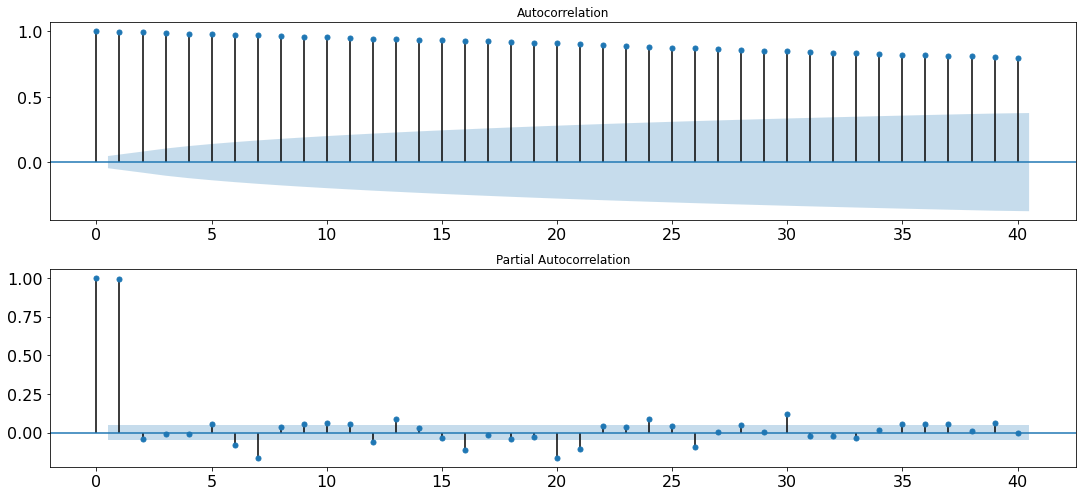

In [169]:
N_LAGS = 40
SIGNIFICANCE_LEVEL = 0.05

fig, ax = plt.subplots(2, 1)
plot_acf(df.close, ax=ax[0], lags=N_LAGS, 
         alpha=SIGNIFICANCE_LEVEL)
plot_pacf(df.close, ax=ax[1], lags=N_LAGS, 
          alpha=SIGNIFICANCE_LEVEL)

plt.tight_layout()
#plt.savefig('images/ch3_im8.png')
plt.show()

## Volatility

Average return: 0.53%


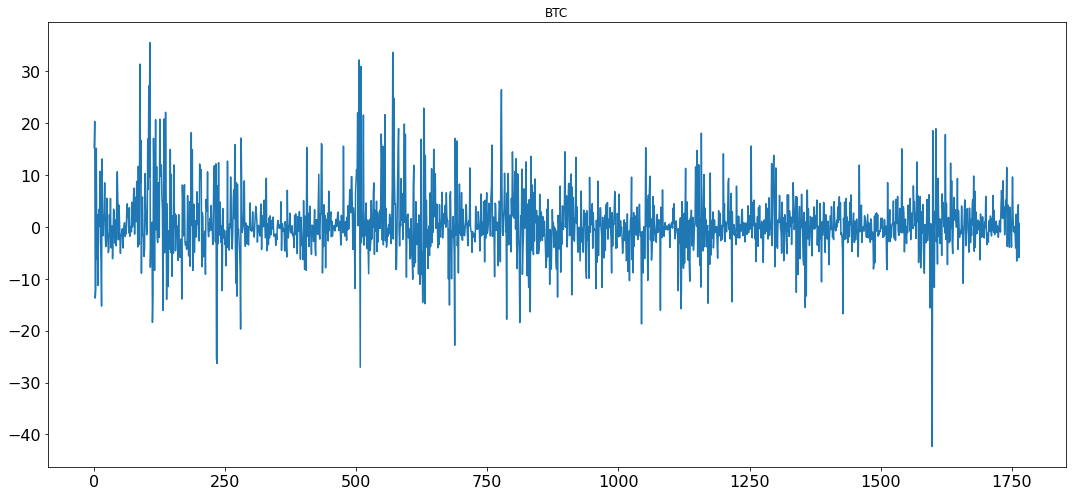

In [170]:

returns = 100 * df['close'].pct_change().dropna()
returns.name = 'asset_returns'
print(f'Average return: {round(returns.mean(), 2)}%')
returns.plot(title= 'BTC');

plt.tight_layout()
# plt.savefig('images/ch5_im1.png')
plt.show()

# Explore data visually

In [171]:
df= df.set_index('date')

## Value

In [172]:
# Using plotly.express
import plotly.express as px
import plotly.graph_objects as go

import pandas as pd

fig = go.Figure([go.Scatter(x=df.index, y=df['close'])])

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
    
)
fig.show()

## Volume

In [173]:
# Using plotly.express
import plotly.express as px
import plotly.graph_objects as go

import pandas as pd

fig = go.Figure([go.Scatter(x=df.index, y=df['volume'])])

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
    
)
fig.show()

KeyError: ignored

## Technical indicators

In [ ]:
#TA =df.drop(['high', 'low', 'open', 'volume', 'adj close', 'percent_change', 'short_result', 'Next_day', 'Next_5', 'Next_30'], axis = 1)

In [ ]:
TA = df
corr = TA.corr(method = 'pearson')
corr

In [ ]:
len(TA.columns)
TA['future'] = TA.close.shift(-1)

In [ ]:
TA = TA.dropna()
TA = TA.drop(['NEW_SMA_5'], axis =1)

In [ ]:
TA.head()

In [ ]:
X = TA.iloc[:,0:(len(TA.columns)-1)]
y = TA.iloc[:,-1]

## Feature importance

https://towardsdatascience.com/explaining-feature-importance-by-example-of-a-random-forest-d9166011959e

In [ ]:
import pandas as pd

from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.8, random_state = 42, shuffle= False)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators = 100,
                           n_jobs = -1,
                           oob_score = True,
                           bootstrap = True,
                           random_state = 42)
rf.fit(X_train, y_train)

print('R^2 Training Score: {:.2f} \nOOB Score: {:.2f} \nR^2 Validation Score: {:.2f}'.format(rf.score(X_train, y_train), 
                                                                                             rf.oob_score_,
                                                                                             rf.score(X_valid, y_valid)))
                          

## RFPIMP

In [ ]:
!pip install rfpimp 

In [ ]:
from sklearn.metrics import r2_score
from rfpimp import permutation_importances

def r2(rf, X_train, y_train):
    return r2_score(y_train, rf.predict(X_train))

perm_imp_rfpimp = permutation_importances(rf, X_train, y_train, r2)

In [ ]:
perm_imp_rfpimp = perm_imp_rfpimp.reset_index()

## ELI5

In [ ]:
pip install eli5

In [ ]:
def imp_df(column_names, importances):
    df = pd.DataFrame({'feature': column_names,
                       'feature_importance': importances}) \
           .sort_values('feature_importance', ascending = False) \
           .reset_index(drop = True)
    return df

In [ ]:

import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(rf, cv = None, refit = False, n_iter = 50).fit(X_train, y_train)
perm_imp_eli5 = imp_df(X_train.columns, perm.feature_importances_)

In [ ]:
import matplotlib.pyplot as plt
y_pos = np.arange(len(perm_imp_eli5))
plt.figure(figsize=(20,20))
plt.barh(y_pos, perm_imp_eli5.feature_importance,  align='center', alpha=0.5)
plt.yticks(y_pos, perm_imp_eli5.feature)
plt.xlabel('Importance')
plt.title('TA')

In [ ]:
# plotting a feature importance dataframe (horizontal barchart)
def var_imp_plot(imp_df, title):
    imp_df.columns = ['feature', 'feature_importance']
    plt.figure(figsize=(20,20))
    sns.barplot(x = 'feature_importance', y = 'feature', data = imp_df, orient = 'h', color = 'orange') \
       .set_title(title, fontsize = 20)

In [ ]:

from sklearn.base import clone 

def drop_col_feat_imp(model, X_train, y_train, random_state = 42):
    
    # clone the model to have the exact same specification as the one initially trained
    model_clone = clone(model)
    # set random_state for comparability
    model_clone.random_state = random_state
    # training and scoring the benchmark model
    model_clone.fit(X_train, y_train)
    benchmark_score = model_clone.score(X_train, y_train)
    # list for storing feature importances
    importances = []
    
    # iterating over all columns and storing feature importance (difference between benchmark and new model)
    for col in X_train.columns:
        model_clone = clone(model)
        model_clone.random_state = random_state
        model_clone.fit(X_train.drop(col, axis = 1), y_train)
        drop_col_score = model_clone.score(X_train.drop(col, axis = 1), y_train)
        importances.append(benchmark_score - drop_col_score)
    
    importances_df = imp_df(X_train.columns, importances)
    return importances_df

## Deleting columns that have negative impact


In [ ]:
drop_imp = drop_col_feat_imp(rf, X_train, y_train)
var_imp_plot(drop_imp, 'Drop Column feature importance')

In [ ]:
drop_imp.sort_values(by= ['feature_importance'])

#drop_imp.to_csv('drop_features_list_BTC.csv')

In [ ]:
drop_imp = drop_imp.set_index('feature')

In [ ]:
to_del = drop_imp.drop("close", axis =0)

In [ ]:
to_del = to_del[(to_del['feature_importance']<0)]

In [ ]:
to_del= to_del.reset_index()

In [ ]:
to_del.head()

In [ ]:
del_list = to_del["feature"].tolist()


In [ ]:
clean = TA.drop(del_list, axis=1)
clean = clean.reset_index()

In [ ]:
clean.head(2)

In [ ]:
#clean = clean.drop(['date', 'SAR'], axis =1)

# Cleaned Dataset

In [ ]:
#clean = clean.drop(['SAR'], axis =1)

In [ ]:
len(clean.columns)

In [ ]:
clean.head()



In [ ]:
X = clean.iloc[:,0:(len(clean.columns)-1)]
y = clean.iloc[:,-1]

In [ ]:
X.to_csv('cleaned_X_ETH.csv')
y.to_csv('cleaned_y_ETH.csv')
clean.to_csv('cleaned_ETH.csv')

# Correlation matrix on cleaned data

In [ ]:
#get correlations of each features in dataset
corrmat = clean.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(40,40))
#plot heat map
g=sns.heatmap(clean[top_corr_features].corr(),annot=True,cmap="RdYlGn")

# Decomposition

In [ ]:

from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot

In [ ]:
df = df.reset_index()

In [ ]:
df =pd.read_csv('cleaned_BTC.csv')
#btc =pd.read_csv('btc_w_features.csv')
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df = df.dropna()


In [ ]:
df.head()

In [ ]:
df['date'] = pd.to_datetime(df['date'], format="%Y-%m-%d")


In [ ]:
df= df.set_index('date')

In [ ]:
month = df.resample('M').last()

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
seasonal_decompose(month.close).plot()
plt.show()